<a href="https://colab.research.google.com/github/NgocDuonglab/Intro-to-CS-PROJECT/blob/main/Project_Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
images = sorted(os.listdir("/content/drive/MyDrive/Project_for_Intro_to_CS/Mask_RCNN/dataset/train"))
masks = sorted(os.listdir("/content/drive/MyDrive/Project_for_Intro_to_CS/Mask_RCNN/dataset/mask"))
# images = sorted(os.listdir("/content/drive/MyDrive/Draft/Images"))
# masks = sorted(os.listdir("/content/drive/MyDrive/Draft/mask"))

In [4]:
idx = 0
img = Image.open("/content/drive/MyDrive/Project_for_Intro_to_CS/Mask_RCNN/dataset/train/" + images[idx]).convert("RGB")
mask = Image.open("/content/drive/MyDrive/Project_for_Intro_to_CS/Mask_RCNN/dataset/mask/" + masks[idx])
# img = Image.open("/content/drive/MyDrive/Draft/Images/" + images[idx]).convert("RGB")
# mask = Image.open("/content/drive/MyDrive/Draft/mask/" + masks[idx])

In [5]:
np.unique(mask)

array([  0, 128], dtype=uint8)

In [6]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self , images , masks):
        self.imgs = images
        self.masks = masks

    def __getitem__(self , idx):
        img = Image.open("/content/drive/MyDrive/Project_for_Intro_to_CS/Mask_RCNN/dataset/train/" + self.imgs[idx]).convert("RGB")
        mask = Image.open("/content/drive/MyDrive/Project_for_Intro_to_CS/Mask_RCNN/dataset/mask/" + self.masks[idx]).convert("L")
        # img = Image.open("/content/drive/MyDrive/Draft/Images/" + self.imgs[idx]).convert("RGB")
        # mask = Image.open("/content/drive/MyDrive/Draft/mask/" + self.masks[idx]).convert("L")
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        # obj_ids = obj_ids[1:]  # train luôn background nha (k báo lỗi nhưng train sẽ thiếu class)
        num_objs = len(obj_ids)
        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        for i in range(num_objs):
            # masks[i][mask == i+1] = True  # cách này chỉ đúng nếu label đánh theo thứ tự
            masks[i] = (mask == obj_ids[i])
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])
        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        return T.ToTensor()(img), target

    def __len__(self):
        return len(self.imgs)

In [7]:
binary_mask_1 = np.array(mask) == 1
binary_mask_2 = np.array(mask) == 2

img_1 = Image.fromarray((binary_mask_1 * 255).astype(np.uint8))
img_2 = Image.fromarray((binary_mask_2 * 255).astype(np.uint8))

In [8]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

In [9]:
transform = T.ToTensor()

In [10]:
def custom_collate(data):
  return data

In [11]:
images = sorted(os.listdir("/content/drive/MyDrive/Project_for_Intro_to_CS/Mask_RCNN/dataset/train"))
masks = sorted(os.listdir("/content/drive/MyDrive/Project_for_Intro_to_CS/Mask_RCNN/dataset/mask"))
# images = sorted(os.listdir("/content/drive/MyDrive/Draft/Images"))
# masks = sorted(os.listdir("/content/drive/MyDrive/Draft/mask"))
num = int(0.9 * len(images))
num = num if num % 2 == 0 else num + 1
train_imgs_inds = np.random.choice(range(len(images)) , num , replace = False)
val_imgs_inds = np.setdiff1d(range(len(images)) , train_imgs_inds)
train_imgs = np.array(images)[train_imgs_inds]
val_imgs = np.array(images)[val_imgs_inds]
train_masks = np.array(masks)[train_imgs_inds]
val_masks = np.array(masks)[val_imgs_inds]

In [12]:
train_dl = torch.utils.data.DataLoader(CustDat(train_imgs , train_masks) ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 1 ,
                                 pin_memory = True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(CustDat(val_imgs , val_masks) ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 1 ,
                                 pin_memory = True if torch.cuda.is_available() else False)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
model.to(device)

In [15]:
params = [p for p in model.parameters() if p.requires_grad]

In [16]:
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
all_train_losses = []
all_val_losses = []
flag = False

for epoch in range(100):
  train_epoch_loss = 0
  val_epoch_loss = 0
  model.train()
  for i , dt in enumerate(train_dl):
    imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
    targ = [dt[0][1] , dt[1][1]]
    # imgs = dt[0]
    # targ = dt[1]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
    loss = model(imgs , targets)
    if not flag:
      print(loss)
      flag = True
      losses = sum([l for l in loss.values()])
      train_epoch_loss += losses.cpu().detach().numpy()
      optimizer.zero_grad()
      losses.backward()
      optimizer.step()
      all_train_losses.append(train_epoch_loss)
  with torch.no_grad():
    for j , dt in enumerate(val_dl):
      imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
      targ = [dt[0][1] , dt[1][1]]
      targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
      loss = model(imgs , targets)
      losses = sum([l for l in loss.values()])
      val_epoch_loss += losses.cpu().detach().numpy()
      all_val_losses.append(val_epoch_loss)
  print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss)

{'loss_classifier': tensor(0.7616, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0002, grad_fn=<DivBackward0>), 'loss_mask': tensor(1.2489, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.7025, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.2736, grad_fn=<DivBackward0>)}
0    2.9866487979888916    4.674654006958008
1    0    4.766383171081543
2    0    4.6679487228393555
3    0    4.669058084487915
4    0    4.666670322418213
5    0    4.668781518936157
6    0    4.7690088748931885
7    0    4.765216588973999


In [ ]:
loss

NameError: ignored

In [ ]:
losses

NameError: ignored

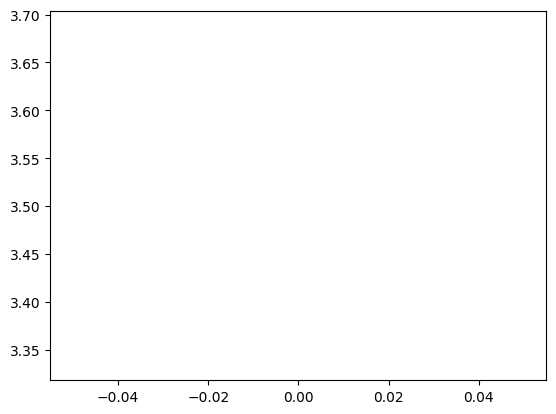

In [ ]:
plt.plot(all_train_losses)

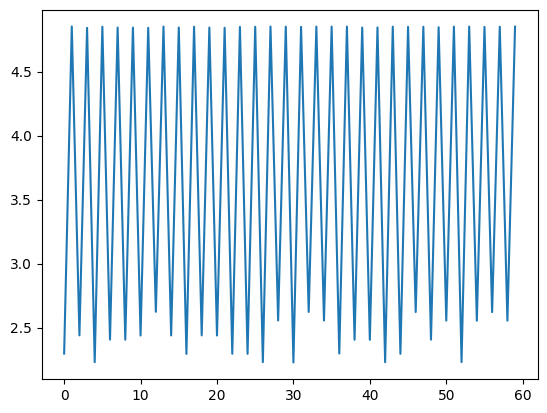

In [ ]:
plt.plot(all_val_losses)

In [ ]:
!wget https://cdn.pixabay.com/photo/2018/09/18/21/08/couple-3687274_960_720.jpg

In [ ]:
model.eval()
img = Image.open("/content/drive/MyDrive/Project_for_Intro_to_CS/Mask_RCNN/dataset/train/1.jpg")
transform = T.ToTensor()
ig = transform(img)
with torch.no_grad():
    pred = model([ig.to(device)])

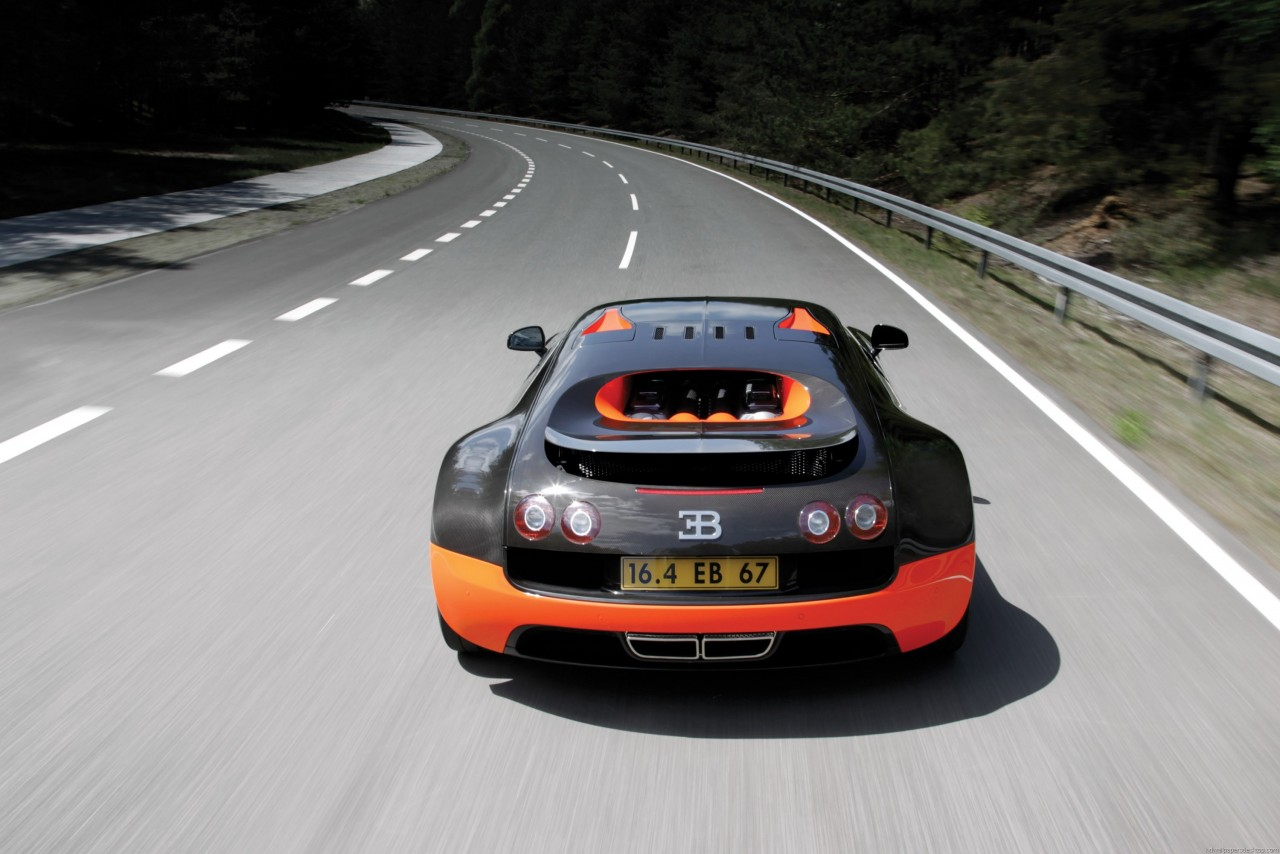

In [ ]:
img

In [ ]:
pred

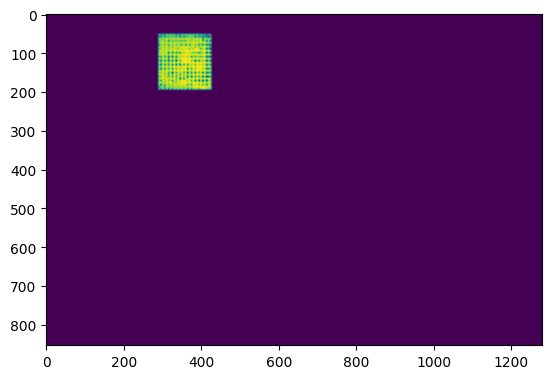

In [ ]:
plt.imshow((pred[0]["masks"][0].cpu().detach().numpy() * 255).astype("uint8").squeeze())

In [ ]:
img.size

(1280, 854)